In [ ]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import pickle
%config Completer.use_jedi = False
import tensorflow as tf
from sklearn import preprocessing
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/gdrive')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning:

Config option `use_jedi` not recognized by `IPCompleter`.



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [ ]:
#open pkl
with open('sensor_data.pkl', 'rb') as f:
    data = pickle.load(f)
df = pd.DataFrame(data)
df.dropna(inplace = True) 

In [ ]:
df.describe()

,Col0,Col1,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,Col10,Col11,Col12,Col13,Col14,Col15,Col16,Col17,Col18,Col19,Col20,Col21,Output
count,15971.000000,15971.000000,15971.000000,15971.000000,15971.000000,15971.000000,15971.000000,15971.000000,15971.000000,15971.000000,15971.000000,15971.000000,15971.000000,15971.000000,15971.000000,15971.000000,15971.000000,15971.000000,15971.000000,15971.000000,15971.000000,15971.000000,15971.000000
mean,0.188769,34.871220,54.719672,719.619834,47.797849,46.603012,63.106288,1.449085,83.236925,66.414348,5.764771,3.886180,5.165219,160.992759,18.720422,167.086164,90.579983,204.656049,76.506181,114.076067,9.239438,0.514137,0.000755
std,0.391260,40.495812,1.407458,43.952622,31.024828,34.027504,26.242439,0.096486,10.965385,22.832346,2.201301,1.337357,2.126720,71.624995,17.878912,52.254194,60.903419,159.546773,93.190510,147.521304,48.057433,0.183012,2.477850
min,0.000000,-185.229729,51.954546,569.733796,0.327932,0.000000,0.000000,1.000550,0.695478,5.967882,0.000965,0.001447,0.013021,0.000000,0.000000,1.076710,0.286458,34.658565,-425.240162,-325.603299,0.050904,0.000405,-35.344329
25%,0.000000,42.248262,53.636364,712.094907,23.918547,7.665000,59.580000,1.396147,77.694740,47.629123,4.648078,3.668981,4.211792,185.648148,0.043403,160.216962,66.844773,141.750372,75.693070,59.036675,0.396303,0.447357,0.000000
50%,0.000000,47.951260,54.500000,733.707562,39.720775,59.632500,69.515000,1.449653,87.949052,66.283275,5.494792,3.896605,4.919946,191.464120,28.234954,180.101997,83.025174,157.798032,94.473235,74.422743,0.462693,0.523693,0.000000
75%,0.000000,53.289190,55.590910,747.878086,64.293728,74.465000,76.962500,1.506221,90.393519,86.962133,6.857928,4.111690,5.644290,195.196759,34.982639,195.679615,98.454551,176.385272,112.485749,92.756469,0.553301,0.601375,0.000000
max,1.000000,88.314690,63.477272,812.210648,199.567178,99.353333,99.305000,2.127170,98.101128,103.752894,23.700810,23.700810,23.690683,474.074074,118.504051,264.954117,426.484375,709.852431,203.031684,708.220486,395.930128,4.229263,33.764468


In [ ]:
df

,Col0,Col1,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,Col10,Col11,Col12,Col13,Col14,Col15,Col16,Col17,Col18,Col19,Col20,Col21,Output
date,,,,,,,,,,,,,,,,,,,,,,,
2019-12-01 20:15:00,0.0,46.999207,54.409090,727.719907,15.693373,59.600000,59.5800,1.422936,90.509259,83.839699,4.199942,3.548900,3.732175,188.086971,35.860340,161.349826,73.914931,143.292721,87.434896,69.377790,0.458104,0.515832,0.000000
2019-12-01 20:30:00,0.0,46.999207,54.545455,727.719907,14.633970,84.344325,81.9275,1.429543,88.006366,94.138214,4.207176,3.572049,3.787616,188.078704,35.841049,163.320312,78.456597,140.979456,84.863715,62.522859,0.480385,0.556511,0.000000
2019-12-01 20:45:00,0.0,46.999673,54.454546,727.777778,16.210609,89.286667,89.3750,1.433111,81.481481,76.654731,4.168113,3.530937,3.746263,188.155864,35.734954,156.406250,78.057292,146.038773,78.348958,67.981481,0.499068,0.534497,0.000000
2019-12-01 21:00:00,0.0,47.288057,54.363635,729.728350,16.355613,84.443333,84.4100,1.440972,75.053048,55.931713,4.131944,3.573495,4.429832,188.634259,34.191744,161.179832,75.338542,143.236400,85.841291,67.897859,0.467419,0.525973,5.043403
2019-12-01 21:15:00,0.0,47.146217,54.272724,728.877315,24.717882,88.221667,88.3800,1.441683,68.610147,59.892940,4.108796,3.547936,4.440208,188.148148,34.012277,158.629919,74.448661,144.024884,84.181258,69.576224,0.469323,0.516915,7.104311
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-29 17:45:00,1.0,63.475134,55.409090,766.586968,76.934762,4.432500,64.5450,1.405266,85.073061,60.177951,5.594618,3.707988,3.795401,186.091821,36.700424,190.957755,66.307292,150.434028,124.650463,84.126736,0.347235,0.440773,0.015191
2020-08-29 18:00:00,0.0,64.870318,55.409089,769.149552,85.245949,69.504000,69.5150,1.418475,72.207755,73.148148,5.590278,3.729745,3.554205,185.860340,36.736111,199.903067,92.778646,145.699508,107.124421,52.920862,0.464118,0.636781,0.000000
2020-08-29 18:15:00,0.0,62.174968,55.393939,764.198909,96.657986,79.432500,76.9625,1.409746,62.914738,50.694444,5.588349,3.684689,3.967593,185.671296,36.523954,189.236111,75.434028,152.575231,113.802083,77.141204,0.398624,0.494405,0.000000


In [ ]:
train_size = int(len(df) * 0.85)
train = df[:train_size]
test = df[train_size:]

In [ ]:
uni_data = train['Output']
validation = test["Output"]
uni_data.head()

date
2019-12-01 20:15:00    0.000000
2019-12-01 20:30:00    0.000000
2019-12-01 20:45:00    0.000000
2019-12-01 21:00:00    5.043403
2019-12-01 21:15:00    7.104311
Name: Output, dtype: float64

In [ ]:
uni_data = uni_data.values.reshape(-1, 1)
scaler_x = preprocessing.MinMaxScaler()
x_rescaled = scaler_x.fit_transform(uni_data)

In [ ]:
uni_data.shape

(13575, 1)

In [ ]:
def custom_ts_univariate_data_prep(dataset, start, end, window, horizon):
    X = []
    y = []
    start = start + window
    if end is None:
        end = len(dataset) - horizon
    for i in range(start, end):
        indicesx = range(i-window, i)
        X.append(np.reshape(dataset[indicesx], (window, 1)))
        indicesy = range(i,i+horizon)
        y.append(dataset[indicesy])
    return np.array(X), np.array(y)

In [ ]:
univar_hist_window = 96
horizon = 10
TRAIN_SPLIT = 11000

x_train_uni, y_train_uni = custom_ts_univariate_data_prep(x_rescaled, 0, TRAIN_SPLIT,univar_hist_window, horizon)
x_val_uni, y_val_uni = custom_ts_univariate_data_prep(x_rescaled, TRAIN_SPLIT, None,univar_hist_window,horizon)

In [ ]:
BATCH_SIZE = 256
BUFFER_SIZE = 150

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [ ]:
lstm_model = tf.keras.models.Sequential([
 tf.keras.layers.LSTM(100, input_shape=x_train_uni.shape[-2:],return_sequences=True),
 tf.keras.layers.Dropout(0.2),
 tf.keras.layers.LSTM(units=50,return_sequences=False),
 tf.keras.layers.Dropout(0.2),
 tf.keras.layers.Dense(units=horizon),
])
lstm_model.compile(optimizer='adam', loss='mse')

In [ ]:
model_path_lstm = r'\LSTM_Univarient_1.h5'
EVALUATION_INTERVAL = 100
EPOCHS = 150
history = lstm_model.fit(train_univariate, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL,
                         validation_data=val_univariate,
                         validation_steps=50,verbose =1,
                         callbacks =[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10,verbose=1, mode='min'),
                                     tf.keras.callbacks.ModelCheckpoint(model_path_lstm, monitor='val_loss', save_best_only=True, mode='min', verbose=0)])

Epoch 1/150
100/100 [==============================] - 7s 28ms/step - loss: 0.0733 - val_loss: 0.0012
Epoch 2/150
100/100 [==============================] - 2s 19ms/step - loss: 0.0093 - val_loss: 8.8328e-04
Epoch 3/150
100/100 [==============================] - 2s 19ms/step - loss: 0.0061 - val_loss: 7.8181e-04
Epoch 4/150
100/100 [==============================] - 2s 19ms/step - loss: 0.0052 - val_loss: 8.1555e-04
Epoch 5/150
100/100 [==============================] - 2s 20ms/step - loss: 0.0048 - val_loss: 7.6637e-04
Epoch 6/150
100/100 [==============================] - 2s 19ms/step - loss: 0.0038 - val_loss: 8.8716e-04
Epoch 7/150
100/100 [==============================] - 2s 19ms/step - loss: 0.0035 - val_loss: 7.4175e-04
Epoch 8/150
100/100 [==============================] - 2s 19ms/step - loss: 0.0036 - val_loss: 7.3787e-04
Epoch 9/150
100/100 [==============================] - 2s 19ms/step - loss: 0.0029 - val_loss: 7.4564e-04
Epoch 10/150
100/100 [============================

In [ ]:
Trained_model = tf.keras.models.load_model(model_path_lstm)
Trained_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 96, 100)           40800     
_________________________________________________________________
dropout (Dropout)            (None, 96, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                510       
Total params: 71,510
Trainable params: 71,510
Non-trainable params: 0
_________________________________________________________________


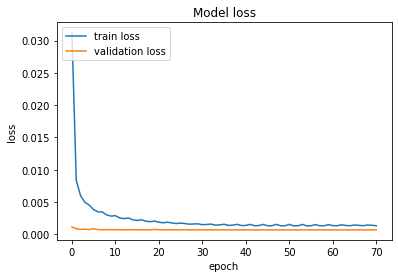

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper left')
plt.rcParams["figure.figsize"] = [16,9]
plt.show()

In [ ]:
uni = df['Output']
window_len = len(df)-train_size
validatehori = uni.tail(96)
validatehist = validatehori.values
scaler_val = preprocessing.MinMaxScaler()
val_rescaled = scaler_x.fit_transform(validatehist.reshape(-1, 1))
result = []

for i in range(0, int((window_len-1)/horizon)+1):
    val_rescaled = val_rescaled.reshape((1, val_rescaled.shape[0], 1))
    Predicted_results = Trained_model.predict(val_rescaled)
    print(f'predicted : {Predicted_results}')
    result.append(Predicted_results[0])
    val_rescaled = np.append(val_rescaled[:,horizon:],[[Predicted_results]])
    print(val_rescaled)
# Predicted_results = Trained_model.predict(val_rescaled)
# Predicted_inver_res = scaler_x.inverse_transform(Predicted_results)

predicted : [[0.39307863 0.4034987  0.4121081  0.431477   0.41981807 0.44432732
  0.4441538  0.44077438 0.44419536 0.44952664]]
[0.56453413 0.58969515 0.46101331 0.5636754  0.54323744 0.63834264
 0.66290253 0.71846286 0.64083298 0.56440532 0.64083298 0.64083298
 0.64083298 0.66625161 0.64083298 0.69184199 0.56406183 0.64083298
 0.64083298 0.71631602 0.64083298 0.74529841 0.66646629 0.66659511
 0.64083298 0.64083298 0.64083298 0.64083298 0.61507085 0.64083298
 0.64083298 0.69222842 0.64083298 0.64083298 0.74375268 0.61507085
 0.76925719 0.         0.64083298 0.64083298 0.64083298 0.64083298
 0.64083298 0.64083298 0.64083298 0.6906827  0.64083298 0.64083298
 0.64083298 0.69209961 0.64083298 0.69214255 0.68797767 0.56826964
 0.71773293 0.64083298 0.64083298 0.64083298 0.64096179 0.64083298
 0.64083298 0.64083298 0.64083298 0.69209961 0.64083298 0.64083298
 0.64083298 0.64083298 0.64083298 0.64083298 0.66221554 0.59446114
 0.64083298 0.40897381 0.64083298 0.64083298 0.64083298 0.82052383
 

In [ ]:
len(result)

240

In [ ]:
result_inv_trans = scaler_x.inverse_transform(result).reshape(-1,)

In [ ]:
result_inv_trans.shape

(2400,)

In [ ]:
from sklearn import metrics
def timeseries_evaluation_metrics_func(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    # print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [ ]:
timeseries_evaluation_metrics_func(validation,result_inv_trans[:-4])

Evaluation metric results:-
MSE is : 31.27941901719013
MAE is : 5.267743759163919
RMSE is : 5.592800641645483
R2 is : -5.122506106496383



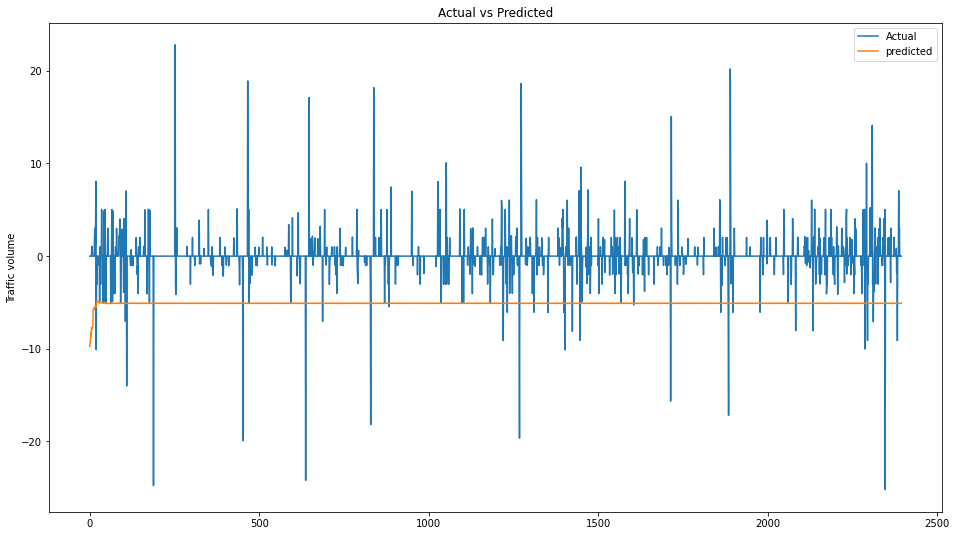

In [ ]:
plt.plot( list(validation))
plt.plot( list(result_inv_trans[:-4]))
plt.title("Actual vs Predicted")
plt.ylabel("Traffic volume")
plt.legend(('Actual','predicted'))
plt.show()

In [ ]:
Bi_lstm_model = tf.keras.models.Sequential([
 tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=True), input_shape=x_train_uni.shape[-2:]),
 tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50)),
 tf.keras.layers.Dense(20, activation='softmax'),
 tf.keras.layers.Dropout(0.2),
 tf.keras.layers.Dense(units=horizon),
])
Bi_lstm_model.compile(optimizer='adam', loss='mse')

In [ ]:
model_path_Bi_lstm = r'\Bi_directional_LSTM_Univarient_1.h5'
EVALUATION_INTERVAL = 100
EPOCHS = 150
history = Bi_lstm_model.fit(train_univariate, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL,
                         validation_data=val_univariate,
                         validation_steps=50,verbose =1,
                         callbacks =[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10,verbose=1, mode='min'),
                                     tf.keras.callbacks.ModelCheckpoint(model_path_Bi_lstm,monitor='val_loss', save_best_only=True, mode='min', verbose=0)])

Epoch 1/150
100/100 [==============================] - 9s 52ms/step - loss: 0.1999 - val_loss: 0.0737
Epoch 2/150
100/100 [==============================] - 4s 41ms/step - loss: 0.0627 - val_loss: 0.0187
Epoch 3/150
100/100 [==============================] - 4s 42ms/step - loss: 0.0235 - val_loss: 0.0055
Epoch 4/150
100/100 [==============================] - 4s 42ms/step - loss: 0.0139 - val_loss: 0.0024
Epoch 5/150
100/100 [==============================] - 4s 42ms/step - loss: 0.0113 - val_loss: 0.0015
Epoch 6/150
100/100 [==============================] - 4s 42ms/step - loss: 0.0092 - val_loss: 0.0011
Epoch 7/150
100/100 [==============================] - 4s 42ms/step - loss: 0.0084 - val_loss: 9.0215e-04
Epoch 8/150
100/100 [==============================] - 4s 43ms/step - loss: 0.0079 - val_loss: 9.2236e-04
Epoch 9/150
100/100 [==============================] - 4s 42ms/step - loss: 0.0067 - val_loss: 8.7069e-04
Epoch 10/150
100/100 [==============================] - 4s 42ms/step -

In [ ]:
Trained_model = tf.keras.models.load_model(model_path_Bi_lstm)
Trained_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 96, 200)           81600     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100)               100400    
_________________________________________________________________
dense_1 (Dense)              (None, 20)                2020      
_________________________________________________________________
dropout_2 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                210       
Total params: 184,230
Trainable params: 184,230
Non-trainable params: 0
_________________________________________________________________


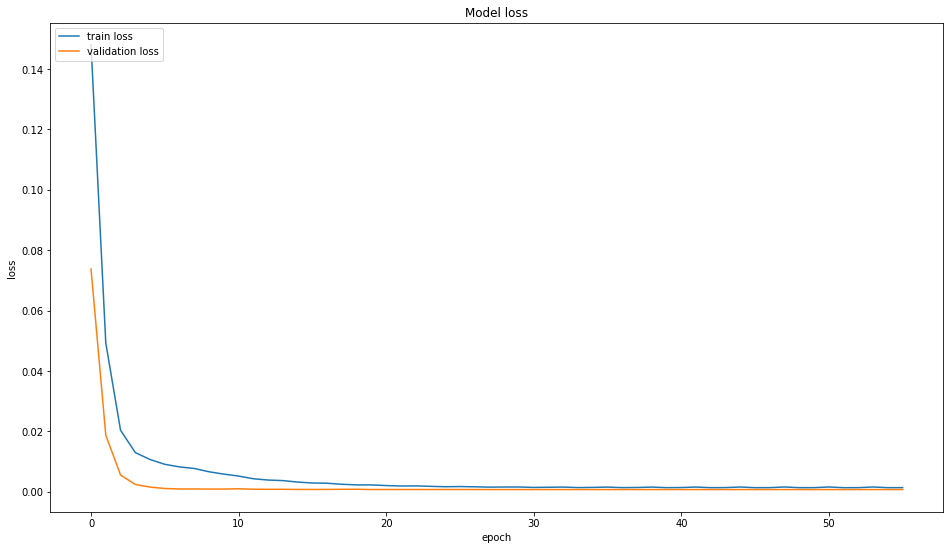

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper left')
plt.rcParams["figure.figsize"] = [16,9]
plt.show()

In [ ]:
uni = df['Output']
window_len = len(df)-train_size
validatehori = uni.tail(96)
validatehist = validatehori.values
scaler_val = preprocessing.MinMaxScaler()
val_rescaled = scaler_x.fit_transform(validatehist.reshape(-1, 1))
result = []

for i in range(0, int((window_len-1)/horizon)+1):
    val_rescaled = val_rescaled.reshape((1, val_rescaled.shape[0], 1))
    Predicted_results = Trained_model.predict(val_rescaled)
    print(f'predicted : {Predicted_results}')
    result.append(Predicted_results[0])
    val_rescaled = np.append(val_rescaled[:,horizon:],[[Predicted_results]])
    print(val_rescaled)

predicted : [[0.51081634 0.5111779  0.51139766 0.5117057  0.5114909  0.51144356
  0.5110377  0.5116453  0.5112762  0.5111592 ]]
[0.56453413 0.58969515 0.46101331 0.5636754  0.54323744 0.63834264
 0.66290253 0.71846286 0.64083298 0.56440532 0.64083298 0.64083298
 0.64083298 0.66625161 0.64083298 0.69184199 0.56406183 0.64083298
 0.64083298 0.71631602 0.64083298 0.74529841 0.66646629 0.66659511
 0.64083298 0.64083298 0.64083298 0.64083298 0.61507085 0.64083298
 0.64083298 0.69222842 0.64083298 0.64083298 0.74375268 0.61507085
 0.76925719 0.         0.64083298 0.64083298 0.64083298 0.64083298
 0.64083298 0.64083298 0.64083298 0.6906827  0.64083298 0.64083298
 0.64083298 0.69209961 0.64083298 0.69214255 0.68797767 0.56826964
 0.71773293 0.64083298 0.64083298 0.64083298 0.64096179 0.64083298
 0.64083298 0.64083298 0.64083298 0.69209961 0.64083298 0.64083298
 0.64083298 0.64083298 0.64083298 0.64083298 0.66221554 0.59446114
 0.64083298 0.40897381 0.64083298 0.64083298 0.64083298 0.82052383
 

In [ ]:
result_inv_trans = scaler_x.inverse_transform(result).reshape(-1,)

In [ ]:
from sklearn import metrics
def timeseries_evaluation_metrics_func(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    # print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [ ]:
timeseries_evaluation_metrics_func(validation,result_inv_trans[:-4])

Evaluation metric results:-
MSE is : 31.06016437727131
MAE is : 5.251978699592747
RMSE is : 5.573164664467694
R2 is : -5.079590096098526



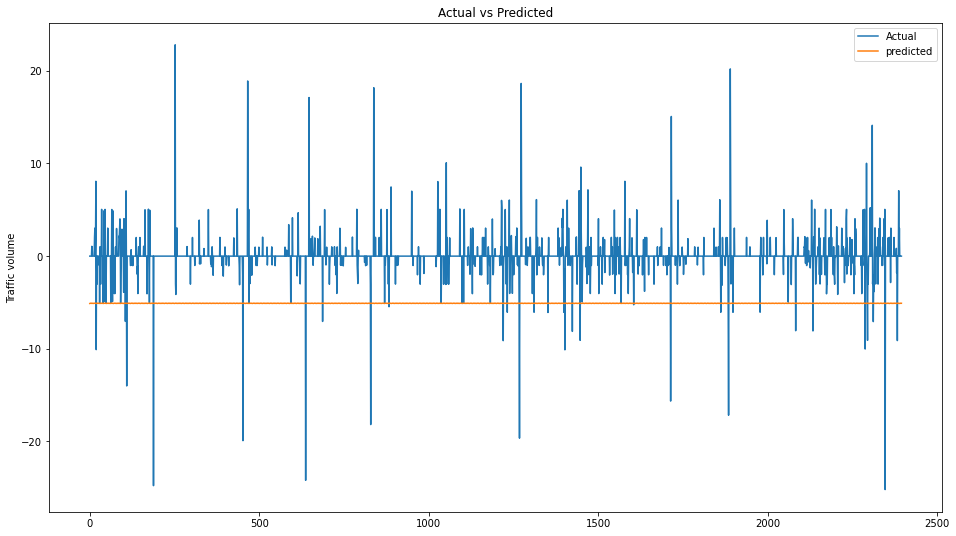

In [ ]:
plt.plot( list(validation))
plt.plot( list(result_inv_trans[:-4]))
plt.title("Actual vs Predicted")
plt.ylabel("Traffic volume")
plt.legend(('Actual','predicted'))
plt.show()

In [ ]:
GRU_model = tf.keras.models.Sequential([
    tf.keras.layers.GRU(100, input_shape=x_train_uni.shape[-2:],return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GRU(units=50,return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=horizon),
])
GRU_model.compile(optimizer='adam', loss='mse')

In [ ]:
model_path_GRU = r'\GRU_Univarient_1.h5'

In [ ]:
EVALUATION_INTERVAL = 100
EPOCHS = 150
history = GRU_model.fit(train_univariate, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL,
                         validation_data=val_univariate,
                         validation_steps=50,verbose =1,
                         callbacks =[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10,verbose=1, mode='min'),
                                     tf.keras.callbacks.ModelCheckpoint(model_path_GRU,monitor='val_loss', save_best_only=True, mode='min', verbose=0)])

Epoch 1/150
100/100 [==============================] - 5s 26ms/step - loss: 0.0692 - val_loss: 9.4519e-04
Epoch 2/150
100/100 [==============================] - 2s 17ms/step - loss: 0.0083 - val_loss: 8.1165e-04
Epoch 3/150
100/100 [==============================] - 2s 17ms/step - loss: 0.0059 - val_loss: 8.7158e-04
Epoch 4/150
100/100 [==============================] - 2s 17ms/step - loss: 0.0051 - val_loss: 8.3089e-04
Epoch 5/150
100/100 [==============================] - 2s 17ms/step - loss: 0.0048 - val_loss: 7.9950e-04
Epoch 6/150
100/100 [==============================] - 2s 17ms/step - loss: 0.0037 - val_loss: 7.8009e-04
Epoch 7/150
100/100 [==============================] - 2s 17ms/step - loss: 0.0036 - val_loss: 7.4215e-04
Epoch 8/150
100/100 [==============================] - 2s 17ms/step - loss: 0.0037 - val_loss: 7.5053e-04
Epoch 9/150
100/100 [==============================] - 2s 17ms/step - loss: 0.0030 - val_loss: 7.5788e-04
Epoch 10/150
100/100 [========================

In [ ]:
Trained_model = tf.keras.models.load_model(model_path_GRU)
Trained_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 96, 100)           30900     
_________________________________________________________________
dropout_3 (Dropout)          (None, 96, 100)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 50)                22800     
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                510       
Total params: 54,210
Trainable params: 54,210
Non-trainable params: 0
_________________________________________________________________


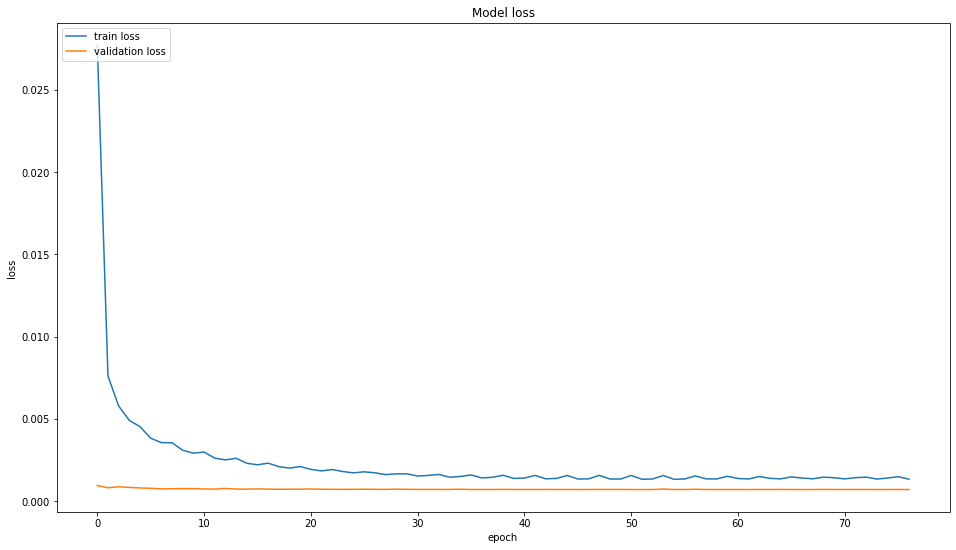

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper left')
plt.rcParams["figure.figsize"] = [16,9]
plt.show()

In [ ]:
uni = df['Output']
window_len = len(df)-train_size
validatehori = uni.tail(96)
validatehist = validatehori.values
scaler_val = preprocessing.MinMaxScaler()
val_rescaled = scaler_x.fit_transform(validatehist.reshape(-1, 1))
result = []

for i in range(0, int((window_len-1)/horizon)+1):
    val_rescaled = val_rescaled.reshape((1, val_rescaled.shape[0], 1))
    Predicted_results = Trained_model.predict(val_rescaled)
    print(f'predicted : {Predicted_results}')
    result.append(Predicted_results[0])
    val_rescaled = np.append(val_rescaled[:,horizon:],[[Predicted_results]])
    print(val_rescaled)

predicted : [[0.3707661  0.38592562 0.39981583 0.41306785 0.42316    0.43328673
  0.4431967  0.4433908  0.44535345 0.45526457]]
[0.56453413 0.58969515 0.46101331 0.5636754  0.54323744 0.63834264
 0.66290253 0.71846286 0.64083298 0.56440532 0.64083298 0.64083298
 0.64083298 0.66625161 0.64083298 0.69184199 0.56406183 0.64083298
 0.64083298 0.71631602 0.64083298 0.74529841 0.66646629 0.66659511
 0.64083298 0.64083298 0.64083298 0.64083298 0.61507085 0.64083298
 0.64083298 0.69222842 0.64083298 0.64083298 0.74375268 0.61507085
 0.76925719 0.         0.64083298 0.64083298 0.64083298 0.64083298
 0.64083298 0.64083298 0.64083298 0.6906827  0.64083298 0.64083298
 0.64083298 0.69209961 0.64083298 0.69214255 0.68797767 0.56826964
 0.71773293 0.64083298 0.64083298 0.64083298 0.64096179 0.64083298
 0.64083298 0.64083298 0.64083298 0.69209961 0.64083298 0.64083298
 0.64083298 0.64083298 0.64083298 0.64083298 0.66221554 0.59446114
 0.64083298 0.40897381 0.64083298 0.64083298 0.64083298 0.82052383
 

In [ ]:
result_inv_trans = scaler_x.inverse_transform(result).reshape(-1,)

In [ ]:
from sklearn import metrics
def timeseries_evaluation_metrics_func(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    # print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [ ]:
timeseries_evaluation_metrics_func(validation,result_inv_trans[:-4])

Evaluation metric results:-
MSE is : 31.336414093215094
MAE is : 5.272321779735403
RMSE is : 5.59789371935687
R2 is : -5.133662090589671



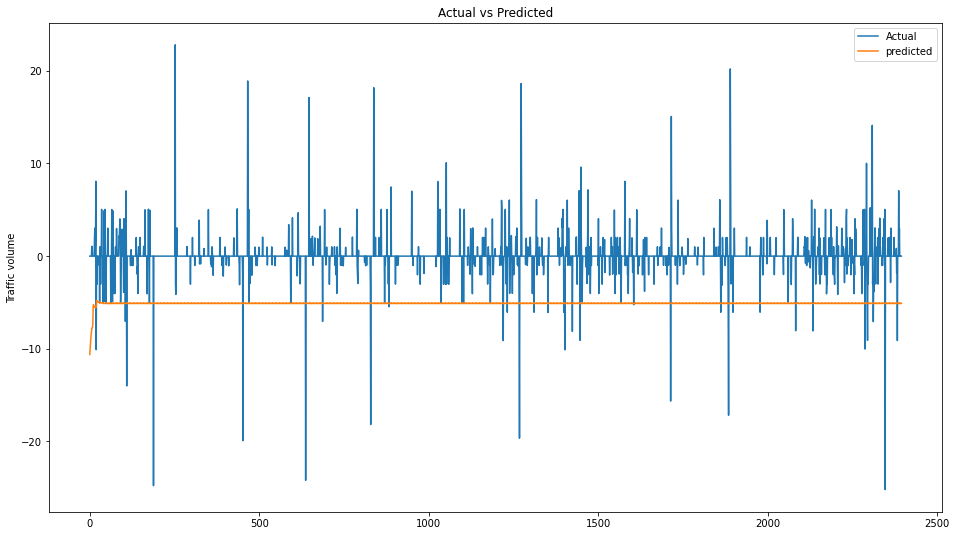

In [ ]:
plt.plot( list(validation))
plt.plot( list(result_inv_trans[:-4]))
plt.title("Actual vs Predicted")
plt.ylabel("Traffic volume")
plt.legend(('Actual','predicted'))
plt.show()

In [ ]:
ED_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(100, input_shape=x_train_uni.shape[-2:], return_sequences=True),
    tf.keras.layers.LSTM(units=50,return_sequences=True),
    tf.keras.layers.LSTM(units=15),
    tf.keras.layers.RepeatVector(y_train_uni.shape[1]), 
    tf.keras.layers.LSTM(units=100,return_sequences=True),
    tf.keras.layers.LSTM(units=50,return_sequences=True),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=1))
])
ED_lstm_model.compile(optimizer='adam', loss='mse')

In [ ]:
model_path_ED_lstm = r'\LSTM_encoder_decoder_Univarient_1.h5'

In [ ]:
EVALUATION_INTERVAL = 100
EPOCHS = 150
history = ED_lstm_model.fit(train_univariate, epochs=EPOCHS,steps_per_epoch=EVALUATION_INTERVAL,validation_data=val_univariate, validation_steps=50,verbose =1,
                              callbacks =[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min'),
                                          tf.keras.callbacks.ModelCheckpoint(model_path_ED_lstm,monitor='val_loss', save_best_only=True, mode='min', verbose=0)])

Epoch 1/150
100/100 [==============================] - 9s 39ms/step - loss: 0.0762 - val_loss: 0.0011
Epoch 2/150
100/100 [==============================] - 3s 26ms/step - loss: 0.0017 - val_loss: 7.1694e-04
Epoch 3/150
100/100 [==============================] - 3s 26ms/step - loss: 0.0012 - val_loss: 7.1584e-04
Epoch 4/150
100/100 [==============================] - 3s 26ms/step - loss: 0.0014 - val_loss: 7.1660e-04
Epoch 5/150
100/100 [==============================] - 3s 25ms/step - loss: 0.0017 - val_loss: 7.1547e-04
Epoch 6/150
100/100 [==============================] - 3s 26ms/step - loss: 0.0012 - val_loss: 7.1718e-04
Epoch 7/150
100/100 [==============================] - 3s 26ms/step - loss: 0.0013 - val_loss: 7.3739e-04
Epoch 8/150
100/100 [==============================] - 3s 26ms/step - loss: 0.0017 - val_loss: 7.2547e-04
Epoch 9/150
100/100 [==============================] - 3s 26ms/step - loss: 0.0012 - val_loss: 7.4465e-04
Epoch 10/150
100/100 [============================

In [ ]:
Trained_model = tf.keras.models.load_model(model_path_ED_lstm)
Trained_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 96, 100)           40800     
_________________________________________________________________
lstm_5 (LSTM)                (None, 96, 50)            30200     
_________________________________________________________________
lstm_6 (LSTM)                (None, 15)                3960      
_________________________________________________________________
repeat_vector (RepeatVector) (None, 10, 15)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 10, 100)           46400     
_________________________________________________________________
lstm_8 (LSTM)                (None, 10, 50)            30200     
_________________________________________________________________
time_distributed (TimeDistri (None, 10, 1)            

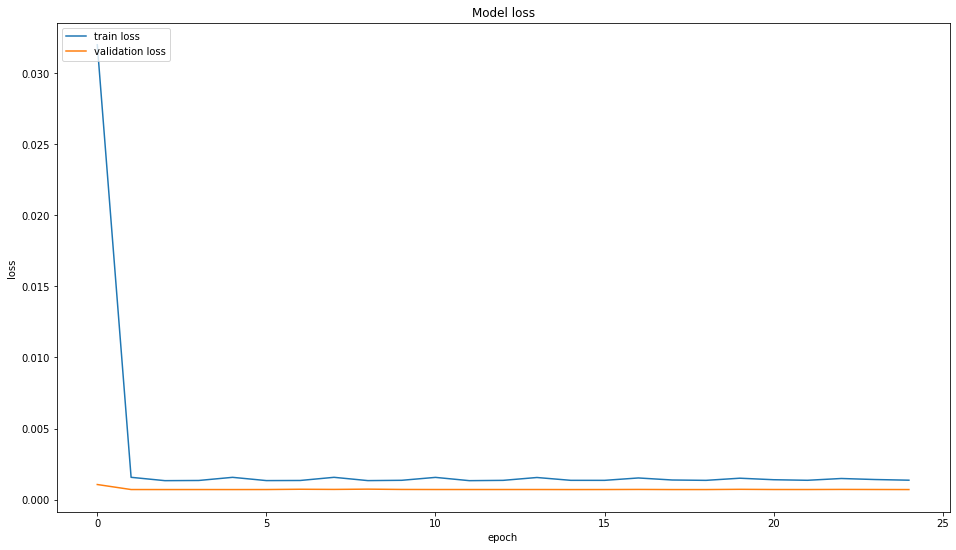

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper left')
plt.rcParams["figure.figsize"] = [16,9]
plt.show()

In [ ]:
uni = df['Output']
window_len = len(df)-train_size
validatehori = uni.tail(96)
validatehist = validatehori.values
scaler_val = preprocessing.MinMaxScaler()
val_rescaled = scaler_x.fit_transform(validatehist.reshape(-1, 1))
result = []

for i in range(0, int((window_len-1)/horizon)+1):
    val_rescaled = val_rescaled.reshape((1, val_rescaled.shape[0], 1))
    Predicted_results = Trained_model.predict(val_rescaled)
    print(f'predicted : {Predicted_results}')
    result.append(Predicted_results[0])
    val_rescaled = np.append(val_rescaled[:,horizon:],[[Predicted_results]])
    print(val_rescaled)

Streaming output truncated to the last 5000 lines.
 0.51166546 0.51185739 0.51149344 0.51154119 0.51163971 0.51168406
 0.5116595  0.51158071 0.51137227 0.51177716 0.5116654  0.51185739
 0.51149344 0.51154119 0.51163971 0.51168406 0.51165944 0.51158071
 0.51137227 0.51177716 0.51166546 0.51185739 0.51149344 0.51154119
 0.51163977 0.511684   0.5116595  0.51158071 0.51137227 0.51177716
 0.5116654  0.51185739 0.51149344 0.51154119 0.51163971 0.51168406
 0.51165944 0.51158071 0.51137227 0.51177716 0.5116654  0.51185739
 0.51149344 0.51154119 0.51163977 0.51168406 0.5116595  0.51158071]
predicted : [[[0.51137227]
  [0.51177716]
  [0.5116654 ]
  [0.5118574 ]
  [0.51149344]
  [0.5115412 ]
  [0.5116397 ]
  [0.51168406]
  [0.51165944]
  [0.5115807 ]]]
[0.51149344 0.51154119 0.51163977 0.511684   0.5116595  0.51158071
 0.51137227 0.51177716 0.5116654  0.51185739 0.51149344 0.51154119
 0.51163971 0.51168406 0.51165944 0.51158071 0.51137227 0.51177716
 0.5116654  0.51185739 0.51149344 0.51154119 0.

In [ ]:
result_inv_trans = scaler_x.inverse_transform(np.array(result).reshape(-1,1)).reshape(-1,)

In [ ]:
from sklearn import metrics
def timeseries_evaluation_metrics_func(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    # print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [ ]:
timeseries_evaluation_metrics_func(validation,result_inv_trans[:-4])

Evaluation metric results:-
MSE is : 30.937316193369494
MAE is : 5.240242210592523
RMSE is : 5.562132342309871
R2 is : -5.055544292827771



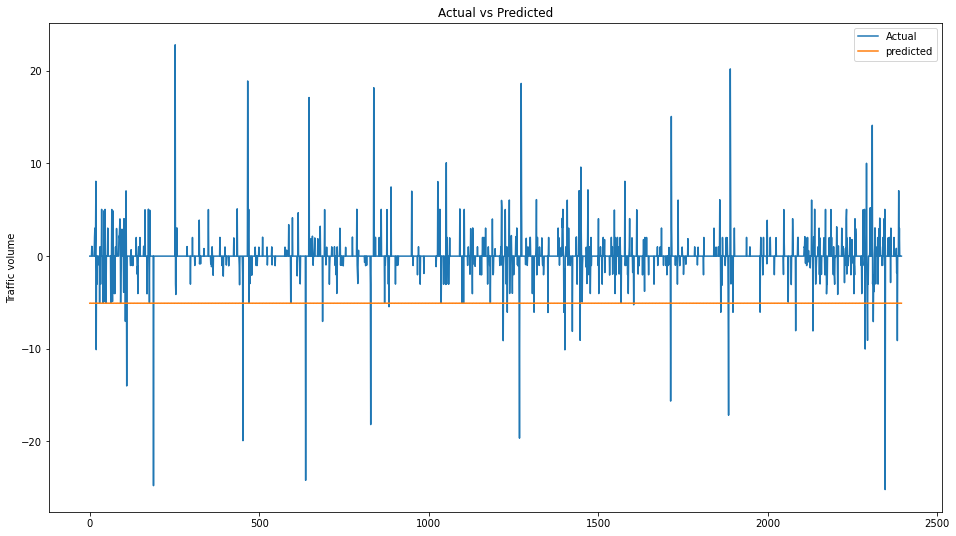

In [ ]:
plt.plot( list(validation))
plt.plot( list(result_inv_trans[:-4]))
plt.title("Actual vs Predicted")
plt.ylabel("Traffic volume")
plt.legend(('Actual','predicted'))
plt.show()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPool1D
from tensorflow.keras.layers import Dropout
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(x_train_uni.shape[1], x_train_uni.shape[2])))
model.add(MaxPool1D(pool_size=2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(30, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(horizon))
model.compile(optimizer='adam', loss='mse')

In [ ]:
model_path_CNN = r'\CNN_Univarient_1.h5'

In [ ]:
EVALUATION_INTERVAL = 100
EPOCHS = 150
history = model.fit(train_univariate, epochs=EPOCHS,steps_per_epoch=EVALUATION_INTERVAL,validation_data=val_univariate, validation_steps=50,verbose =1,
                              callbacks =[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min'),
                                          tf.keras.callbacks.ModelCheckpoint(model_path_CNN,monitor='val_loss', save_best_only=True, mode='min', verbose=0)])

Epoch 1/150
100/100 [==============================] - 1s 6ms/step - loss: 0.0621 - val_loss: 0.0028
Epoch 2/150
100/100 [==============================] - 0s 4ms/step - loss: 0.0171 - val_loss: 0.0017
Epoch 3/150
100/100 [==============================] - 0s 4ms/step - loss: 0.0108 - val_loss: 0.0016
Epoch 4/150
100/100 [==============================] - 0s 4ms/step - loss: 0.0085 - val_loss: 0.0015
Epoch 5/150
100/100 [==============================] - 0s 4ms/step - loss: 0.0072 - val_loss: 0.0012
Epoch 6/150
100/100 [==============================] - 0s 4ms/step - loss: 0.0056 - val_loss: 0.0012
Epoch 7/150
100/100 [==============================] - 0s 4ms/step - loss: 0.0049 - val_loss: 0.0011
Epoch 8/150
100/100 [==============================] - 0s 4ms/step - loss: 0.0045 - val_loss: 8.4162e-04
Epoch 9/150
100/100 [==============================] - 0s 4ms/step - loss: 0.0034 - val_loss: 8.6806e-04
Epoch 10/150
100/100 [==============================] - 0s 4ms/step - loss: 0.0032 

In [ ]:
Trained_model = tf.keras.models.load_model(model_path_CNN)
Trained_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 94, 64)            256       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 47, 64)            0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 47, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 3008)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 30)                90270     
_________________________________________________________________
dropout_6 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)               

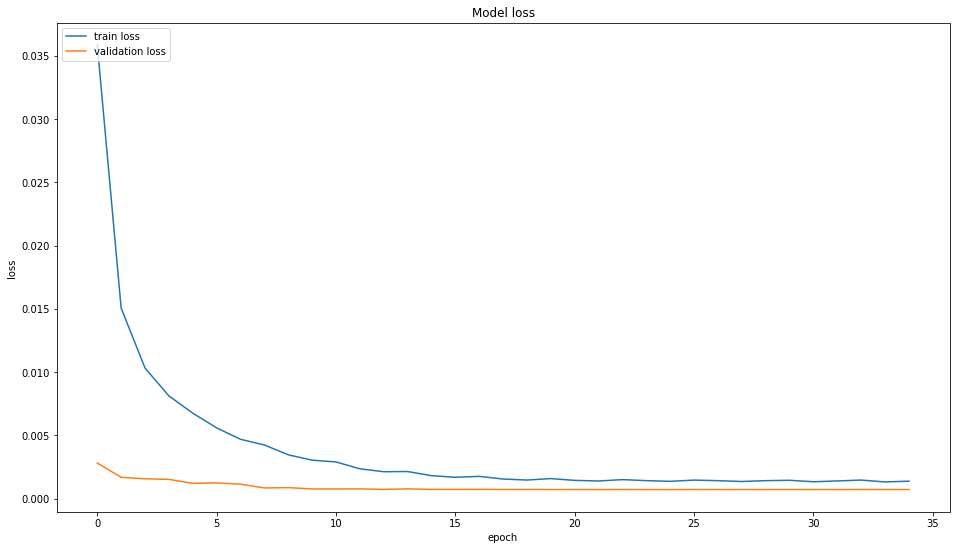

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper left')
plt.rcParams["figure.figsize"] = [16,9]
plt.show()

In [ ]:
uni = df['Output']
window_len = len(df)-train_size
validatehori = uni.tail(96)
validatehist = validatehori.values
scaler_val = preprocessing.MinMaxScaler()
val_rescaled = scaler_x.fit_transform(validatehist.reshape(-1, 1))
result = []

for i in range(0, int((window_len-1)/horizon)+1):
    val_rescaled = val_rescaled.reshape((1, val_rescaled.shape[0], 1))
    Predicted_results = Trained_model.predict(val_rescaled)
    print(f'predicted : {Predicted_results}')
    result.append(Predicted_results[0])
    val_rescaled = np.append(val_rescaled[:,horizon:],[[Predicted_results]])
    print(val_rescaled)

predicted : [[0.54389346 0.55702156 0.54440486 0.53768164 0.5356345  0.5437698
  0.5486017  0.55822694 0.5474051  0.55875504]]
[0.56453413 0.58969515 0.46101331 0.5636754  0.54323744 0.63834264
 0.66290253 0.71846286 0.64083298 0.56440532 0.64083298 0.64083298
 0.64083298 0.66625161 0.64083298 0.69184199 0.56406183 0.64083298
 0.64083298 0.71631602 0.64083298 0.74529841 0.66646629 0.66659511
 0.64083298 0.64083298 0.64083298 0.64083298 0.61507085 0.64083298
 0.64083298 0.69222842 0.64083298 0.64083298 0.74375268 0.61507085
 0.76925719 0.         0.64083298 0.64083298 0.64083298 0.64083298
 0.64083298 0.64083298 0.64083298 0.6906827  0.64083298 0.64083298
 0.64083298 0.69209961 0.64083298 0.69214255 0.68797767 0.56826964
 0.71773293 0.64083298 0.64083298 0.64083298 0.64096179 0.64083298
 0.64083298 0.64083298 0.64083298 0.69209961 0.64083298 0.64083298
 0.64083298 0.64083298 0.64083298 0.64083298 0.66221554 0.59446114
 0.64083298 0.40897381 0.64083298 0.64083298 0.64083298 0.82052383
 0

In [ ]:
result_inv_trans = scaler_x.inverse_transform(result).reshape(-1,)

In [ ]:
from sklearn import metrics
def timeseries_evaluation_metrics_func(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    # print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [ ]:
timeseries_evaluation_metrics_func(validation,result_inv_trans[:-4])

Evaluation metric results:-
MSE is : 30.46014812277399
MAE is : 5.193909501240974
RMSE is : 5.519071309810554
R2 is : -4.962145357750348



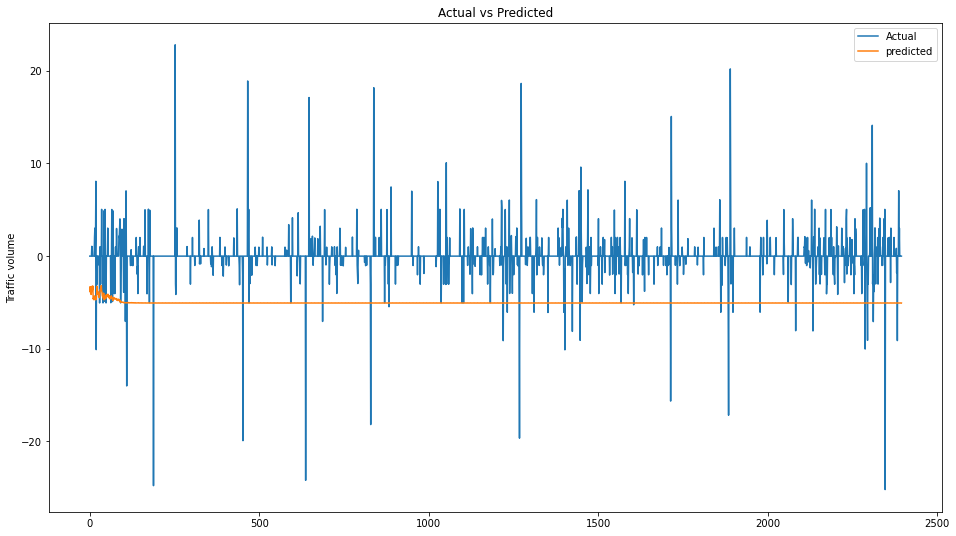

In [ ]:
plt.plot( list(validation))
plt.plot( list(result_inv_trans[:-4]))
plt.title("Actual vs Predicted")
plt.ylabel("Traffic volume")
plt.legend(('Actual','predicted'))
plt.show()